## <center>Sentiment Analysis & Rating Prediction</center>

In [1]:
import pandas as pd
import re
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import matplotlib.pyplot as plt
from pprint import pprint
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from nrclex import NRCLex  


import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK resources (if not already downloaded)
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [2]:
# Load data from CSV file
data_df = pd.read_csv("data/merged_movie_ratings.csv")

# Sentiment Analysis - Calculate Sentiment Score

In [3]:
data_df.head(2)

,reviewid,userid,movieid,rating,review_date,review_text,user_href,review_href,download_flag,movie_title,movie_year,movie_genre
0,4fb026f6760ee33b55006268,darrenhamilton14,62213-dark-shadows,85,2012-05-13,Let\'s leave it all at the door here. I loved ...,/u/darrenhamilton14,/review/4fb026f6760ee33b55006268,1,Dark Shadows,2012,Comedy|Fantasy|
1,5a92f36fc3a36824fd0238c6,Dark+Jedi,62213-dark-shadows,70,2018-02-25,I generally like Tim Burton as well as Johnny...,/u/Dark+Jedi,/review/5a92f36fc3a36824fd0238c6,1,Dark Shadows,2012,Comedy|Fantasy|


In [4]:
# Initialize the lemmatizer and the stop words set
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper function: Map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase and tokenize
    tokens = word_tokenize(text.lower())

    # Remove punctuation, non-alphabetic tokens, and stop words
    words = [word for word in tokens if word.isalpha() and word not in stop_words]

    # POS tagging and lemmatization
    pos_tagged = nltk.pos_tag(words)  # Get POS tags
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tagged]

    # Join the processed words back into a string
    return ' '.join(lemmatized_words)

# Apply preprocessing to the 'review_text' column
data_df['processed_review_text'] = data_df['review_text'].astype(str).apply(preprocess_text)

data_df['processed_review_text']

0       leave door love beetlejuice edward scissorhand...
1       generally like tim burton well johnny depp mov...
2       get hate coastal maine vampire name barnabas c...
3       sorry incapable buying johnny depp immortal yo...
4       really good watch would watch recommend get wr...
                              ...                        
6753                                      dreamworks best
6754    original orgasmatron find back start history c...
6755    watch much convinced treat williams young tomm...
6756    solid enough send trilogy last decently amuse ...
6757    perhaps one sequel many story really rather th...
Name: processed_review_text, Length: 6758, dtype: object

In [5]:
# Import necessary libraries
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Get compound scores for each review and store in a new column
data_df['compound_score'] = data_df['processed_review_text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

data_df[['processed_review_text', 'compound_score']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ceffendy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,processed_review_text,compound_score
0,leave door love beetlejuice edward scissorhand...,0.9559
1,generally like tim burton well johnny depp mov...,0.9622
2,get hate coastal maine vampire name barnabas c...,0.9708
3,sorry incapable buying johnny depp immortal yo...,-0.4019
4,really good watch would watch recommend get wr...,0.5689
...,...,...
6753,dreamworks best,0.6369
6754,original orgasmatron find back start history c...,0.7951
6755,watch much convinced treat williams young tomm...,0.9875
6756,solid enough send trilogy last decently amuse ...,0.9699


In [6]:
# Function to label sentiment based on compound score with adjustable thresholds
def label_sentiment(compound_score, pos_threshold=0.2, neg_threshold=-0.2):
    if compound_score >= pos_threshold:
        return 'Positive'
    elif compound_score <= neg_threshold:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the labeling function to the 'compound_score' column
data_df['sentiment'] = data_df['compound_score'].apply(
    lambda x: label_sentiment(x, pos_threshold=0.2, neg_threshold=-0.2)
)

In [7]:
data_df[['processed_review_text', 'sentiment']]

,processed_review_text,sentiment
0,leave door love beetlejuice edward scissorhand...,Positive
1,generally like tim burton well johnny depp mov...,Positive
2,get hate coastal maine vampire name barnabas c...,Positive
3,sorry incapable buying johnny depp immortal yo...,Negative
4,really good watch would watch recommend get wr...,Positive
...,...,...
6753,dreamworks best,Positive
6754,original orgasmatron find back start history c...,Positive
6755,watch much convinced treat williams young tomm...,Positive
6756,solid enough send trilogy last decently amuse ...,Positive


In [8]:
# Group by sentiment and count occurrences of 'processed_review_text'
temp = data_df.groupby('sentiment').count()['processed_review_text'].reset_index().sort_values(by='processed_review_text', ascending=False)

# Display the result with a background gradient
styled_temp = temp.style.background_gradient(cmap='Purples')

# Output the styled DataFrame for visual representation
styled_temp

,sentiment,processed_review_text
2,Positive,5482
0,Negative,968
1,Neutral,308


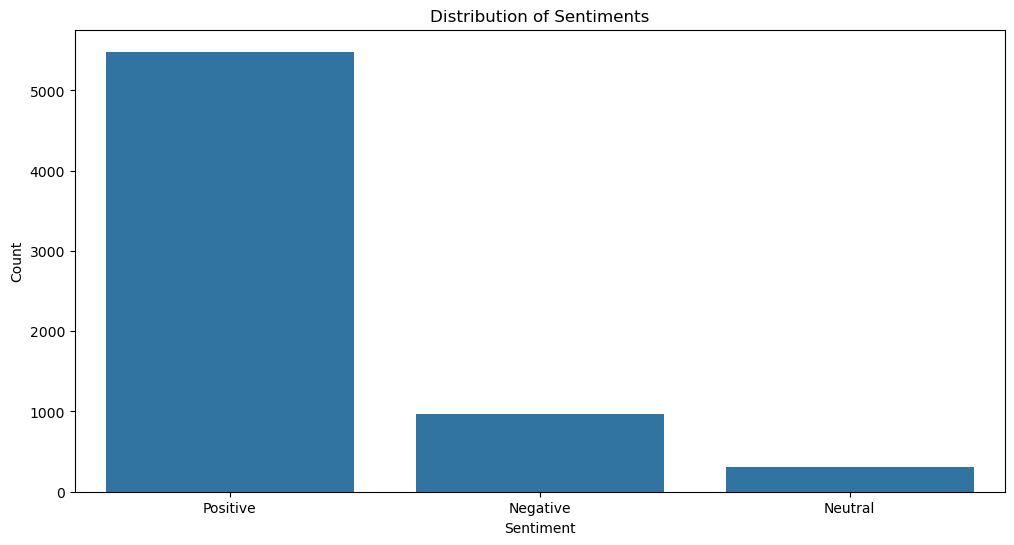

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of sentiments
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=data_df)

# Add titles and labels
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Display the plot
plt.show()

In [10]:
import pandas as pd
import plotly.graph_objects as go
# Group by sentiment and count the occurrences
temp = data_df.groupby('sentiment').count()['processed_review_text'].reset_index().sort_values(by='processed_review_text', ascending=False)

# Create a funnel chart
fig = go.Figure(go.Funnelarea(
    text=temp['sentiment'],  # Sentiment labels
    values=temp['processed_review_text'],  # Counts
    title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))

# Show the funnel chart
fig.show()

## WorldClouds of Positive and Negative Reviews

In [11]:
stop_words = set(stopwords.words('english'))
custom_stop_words = ['movie', 'movies', 'film', 'show', 'story', 'watch', 'director', 'review', 'one', 'character']
stop_words.update(custom_stop_words)

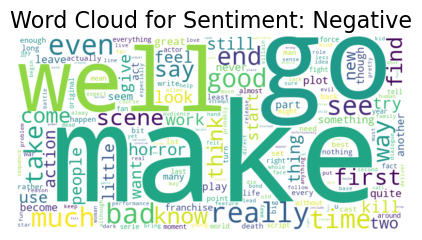

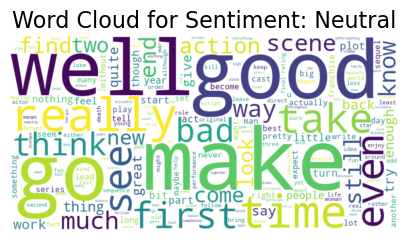

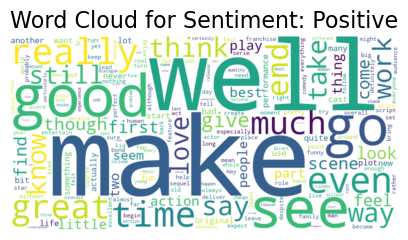

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate comments for each sentiment category into a single string
sentiment_text = data_df.groupby('sentiment')['processed_review_text'].apply(' '.join).reset_index()

# Generate word clouds
for index, row in sentiment_text.iterrows():
    sentiment = row['sentiment']
    text = row['processed_review_text']
    
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    text = " ".join(word for word in text.split() if word.lower() not in stop_words)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Sentiment: {sentiment}", fontsize=16)
    plt.show()

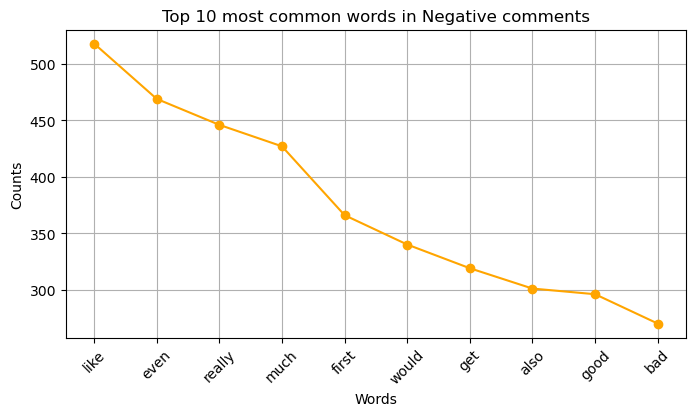

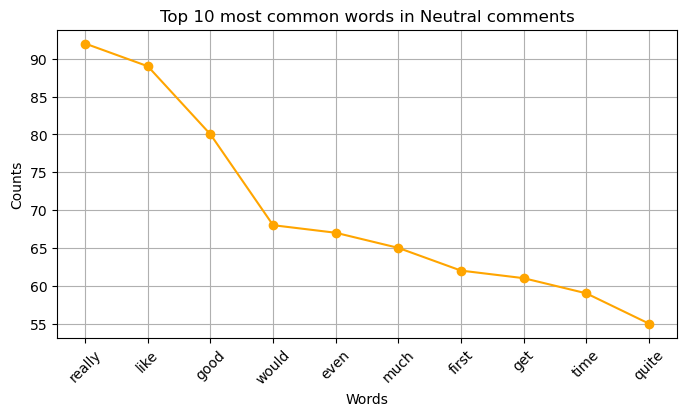

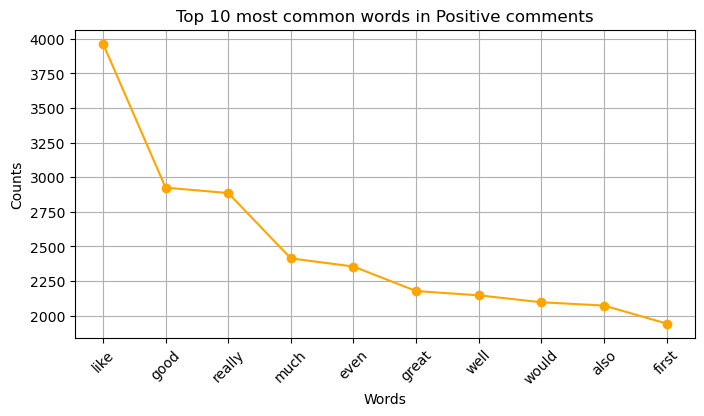

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

def plot_top_words(text, sentiment, top_n=10):
    # Split text into words and filter out stop words and non-alphabetic characters
    words = [word.lower() for word in text.split() if word.isalpha() and word.lower() not in stop_words]
    
    # Calculate word frequency
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(top_n)
    
    if not most_common_words:
        print(f"No valid words found for {sentiment} comments.")
        return

    words, counts = zip(*most_common_words)
    
    plt.figure(figsize=(8, 4))
    plt.plot(words, counts, marker='o', linestyle='-', color='orange')
    plt.title(f'Top {top_n} most common words in {sentiment} comments')
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

for sentiment, group in data_df.groupby('sentiment'):
    text = ' '.join(group['review_text'])  # merge comments
    plot_top_words(text, sentiment) 

# Rating Prediction

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load your data
df_new = data_df

# Adjust rating labels
df_new['rating_label'] = df_new['rating'].apply(lambda x: 'High' if x >= 70 else 'Normal')

# Prepare features and labels
X = df_new['processed_review_text']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_new['rating_label'])

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X)

# Define K-Fold Cross Validation (K=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define and train the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
cv_scores_rf = cross_val_score(model_rf, X_tfidf, y, cv=kf, scoring='accuracy')

# Display cross-validation results
cv_result_rf = pd.DataFrame({
    "Fold": np.arange(1, len(cv_scores_rf) + 1),
    "Accuracy": cv_scores_rf
})

print(cv_result_rf)
# Output the average accuracy across folds
print("Average Accuracy: ", cv_result_rf['Accuracy'].mean())

   Fold  Accuracy
0     1  0.752219
1     2  0.738905
2     3  0.744822
3     4  0.766839
4     5  0.727609
Average Accuracy:  0.7460790604373706
